# RF Testing

In [1]:
!pip show qickdawg

Name: qickdawg
Version: 1.2.1
Summary: Software for full quantum control of nitrogen-vacancy defects and other quantum defects in diamond
Home-page: 
Author: 
Author-email: Andy Mounce <amounce@sandia.gov>, Emmeline Riendeau <eriendeau@uchicago.edu>
License: MIT License 
        
        Copyright 2023 National Technology & Engineering Solutions of Sandia, LLC (NTESS). Under the terms of Contract DE-NA0003525 with NTESS, the U.S. Government retains certain rights in this software.
        
        Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission 

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import qickdawg as qd

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [3]:
qd.start_client('128.95.31.212')

QICK library version mismatch: 0.2.324 remote (the board), 0.2.302 local (the PC)
                        This may cause errors, usually KeyError in QickConfig initialization.
                        If this happens, you must bring your versions in sync.


## Load Default Configuration

In [4]:
default_config = qd.NVConfiguration()

default_config.adc_channel = 0
default_config.edge_counting = True
default_config.high_threshold = 2000
default_config.low_threshold = 500


default_config.mw_channel = 0
default_config.mw_nqz = 1
default_config.mw_gain = 5000

default_config.laser_gate_pmod = 0

default_config.relax_delay_tns = 50 # between each rep, wait for everything to catch up, mostly aom


# Gain Sweep (viewable on oscilliscope)

pmod channel width not tunable when time is very short it seems.

In [5]:
from qickdawg.nvpulsing.rftest import RFTest

config = copy(default_config)

config.readout_integration_tus = qd.max_int_time_tus # necessary but not used
config.mw_fMHz = 2700 # frequency; fMHz, freg, fGHz
config.pulse_len_tns = 100 # pulse duration; tus, tns, treg
config.relax_delay_tns = 20 # 1.62 us
config.trigger_width_tns = 100

config.add_unitless_linear_sweep("gain", 0, 30000, delta=10)
config.pre_init = False # not sure if necessary
config.reps = 1
config.repitition = 1

prog = RFTest(config)
_ = prog.acquire()


Requested 0 to 30000 by 10
Instead using 0 to 30010 by 10 in 3001


## Measure RF Power due to Gain At Specific Frequency (Spectrum Analyzer)

In [6]:
from qickdawg.nvpulsing.rftest_spectrum import RFTestSpectrum

config = copy(default_config)

config.readout_integration_tus = qd.max_int_time_tus # necessary but not used
config.mw_fMHz = 2700 # frequency; fMHz, freg, fGHz
config.pulse_len_tus = 10 # pulse duration; tus, tns, treg
config.relax_delay_tus = 10 # 1.62 us
config.trigger_width_tns = 1000
config.mw_gain = 30000

config.add_unitless_linear_sweep("cycles", 0, 600000, delta=10)
config.pre_init = False # not sure if necessary

prog = RFTestSpectrum(config)
_ = prog.acquire()


Requested 0 to 600000 by 10
Instead using 0 to 600010 by 10 in 60001


## Plot Gain

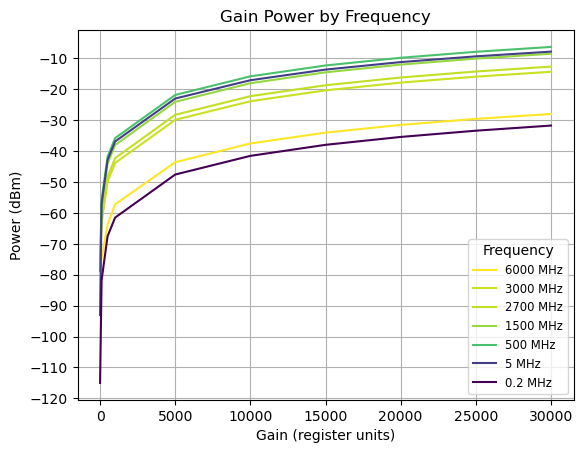

c:\Users\vsmar\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


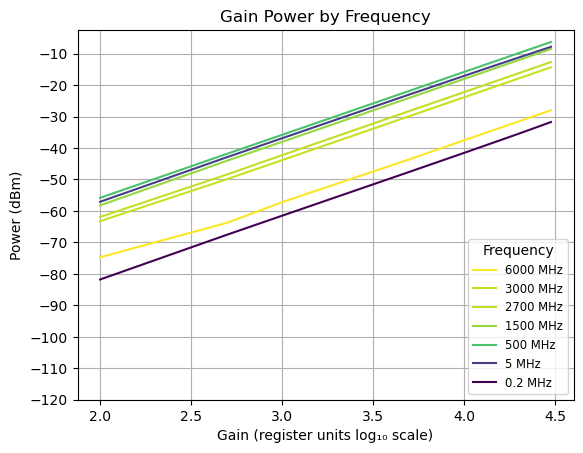

In [7]:
import pandas as pd
import matplotlib.cm as cm

path_to_file = r"C:\Users\vsmar\Desktop\Research\Oscilliscope Data\Qick Dawg RF Gain RFSoC4x2.csv"
rf_gain_df = pd.read_csv(r"C:\Users\vsmar\Desktop\Research\Oscilliscope Data\Qick Dawg RF Gain RFSoC4x2.csv")

gain_col = 'Gain\\MHz'
gain = rf_gain_df[gain_col]

freq_cols = rf_gain_df.columns.drop(gain_col)
sorted_freq_cols = np.flip(sorted(freq_cols, key=lambda x: float(x)))

# come up with a color mapping strategy
max_freq = np.log(float(max(sorted_freq_cols)))
cmap = cm.get_cmap('viridis')

for frequency in sorted_freq_cols:
  plt.plot(gain, rf_gain_df[frequency], color= cmap(np.log(float(frequency))/max_freq), label=f'{frequency} MHz')

plt.title(f'Gain Power by Frequency')
plt.xlabel('Gain (register units)')
plt.ylabel('Power (dBm)')
plt.legend(title='Frequency', fontsize='small', loc='lower right')
plt.yticks(np.arange(-120, 0, 10))
plt.grid()
plt.show()

for frequency in sorted_freq_cols:
  plt.plot(np.log10(gain), rf_gain_df[frequency], color= cmap(np.log(float(frequency))/max_freq), label=f'{frequency} MHz')

plt.title(f'Gain Power by Frequency')
plt.xlabel('Gain (register units log₁₀ scale)')
plt.ylabel('Power (dBm)')
plt.legend(title='Frequency', fontsize='small', loc='lower right')
plt.yticks(np.arange(-120, 0, 10))
plt.grid()
plt.show()

## Envelopes!

In [8]:
# Get the maxv for envelopes on the mw_channel
default_config.soccfg.get_maxv(default_config.mw_channel)
# It appears maxv is tied to gain units 
# this makes sense, since the DAC shouldn't have another way to control amplitude
# if maxv isn't declared then the envelope will use the maximum as default

32766

In [9]:
from qickdawg.nvpulsing.rftest_envelope import RFTest_Envelope

config = copy(default_config)

config.readout_integration_tus = qd.max_int_time_tus # necessary but not used
config.mw_fMHz = 2700 # frequency; fMHz, freg, fGHz
config.pulse_len_tns = 300 # pulse duration; tus, tns, treg
config.pulse_sigma_tns = 100 # sigma for gaussian pulse
config.relax_delay_tns = 500 # 1.62 us
config.trigger_width_tns = 500

config.add_unitless_linear_sweep("gain", 32000, 31900, delta=-1)
config.pre_init = False # not sure if necessary
config.reps = 1
config.repitition = 1

prog = RFTest_Envelope(config)
_ = prog.acquire()


Requested 32000 to 31900 by -1
Instead using 32000 to 31899 by -1 in 101


# Try to generate the CPMG-XY sequence

In [ ]:
from qickdawg.nvpulsing.rftest_cpmg_xy import RFTest_CPMG_XY

config = copy(default_config)
config.mw_fMHz = 1405
config.half_pi_pulse_len_tns = 20
config.pi_pulse_len_tns = 40
config.mw_gain = 30000 # 17 dBm (need an amplifier to reach above -5 dBm)
config.relax_delay_tus = 10
config.n_pulses = 8 # 128-256 or more ideally
config.reps = 1 # number of repetitions
config.pulse_sigma_treg = 60
config.readout_integration_tns = 10

# TODO: add an external trigger
config.trigger_gate_pmod = 0 # PMOD pin for external trigger

# TODO: add pre-init logic
config.pre_init = False

config.add_linear_sweep("tau", "tns", 100, 1000, delta=100)

prog = RFTest_CPMG_XY(config)
_ = prog.acquire()


Requested 100 to 1000 by 100
Instead using 100.91145833333334 to 1009.1145833333335 by 100.91145833333334 in 10 steps


AttributeError: 'NVConfiguration' object has no attribute 'readout_integration_treg'